# Apple Stock Analysis

This notebook is for analyzing Apple stock data.

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.pytorch

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
# Cell 1: Imports and Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('fivethirtyeight')
sns.set_palette("husl")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🔥 Using device: {device}')

🔥 Using device: cpu


In [3]:
# ============================================================================
# Cell 2: Download Stock Data
# ============================================================================

# Stock tickers
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'TSLA']
names = ['Apple', 'Google', 'Microsoft', 'Amazon', 'Tesla']

# Date range (last 2 years for better analysis)
end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

# Download data
stock_data = {}
print('📊 Downloading stock data...\n')
for ticker in tickers:
    df = yf.download(ticker, start=start, end=end, progress=False)
    if df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    stock_data[ticker] = df
    print(f'  {ticker}: {len(df)} records')

print('\n✅ Data downloaded successfully!')

📊 Downloading stock data...

  AAPL: 501 records
  GOOG: 501 records
  MSFT: 501 records
  AMZN: 501 records
  TSLA: 501 records

✅ Data downloaded successfully!


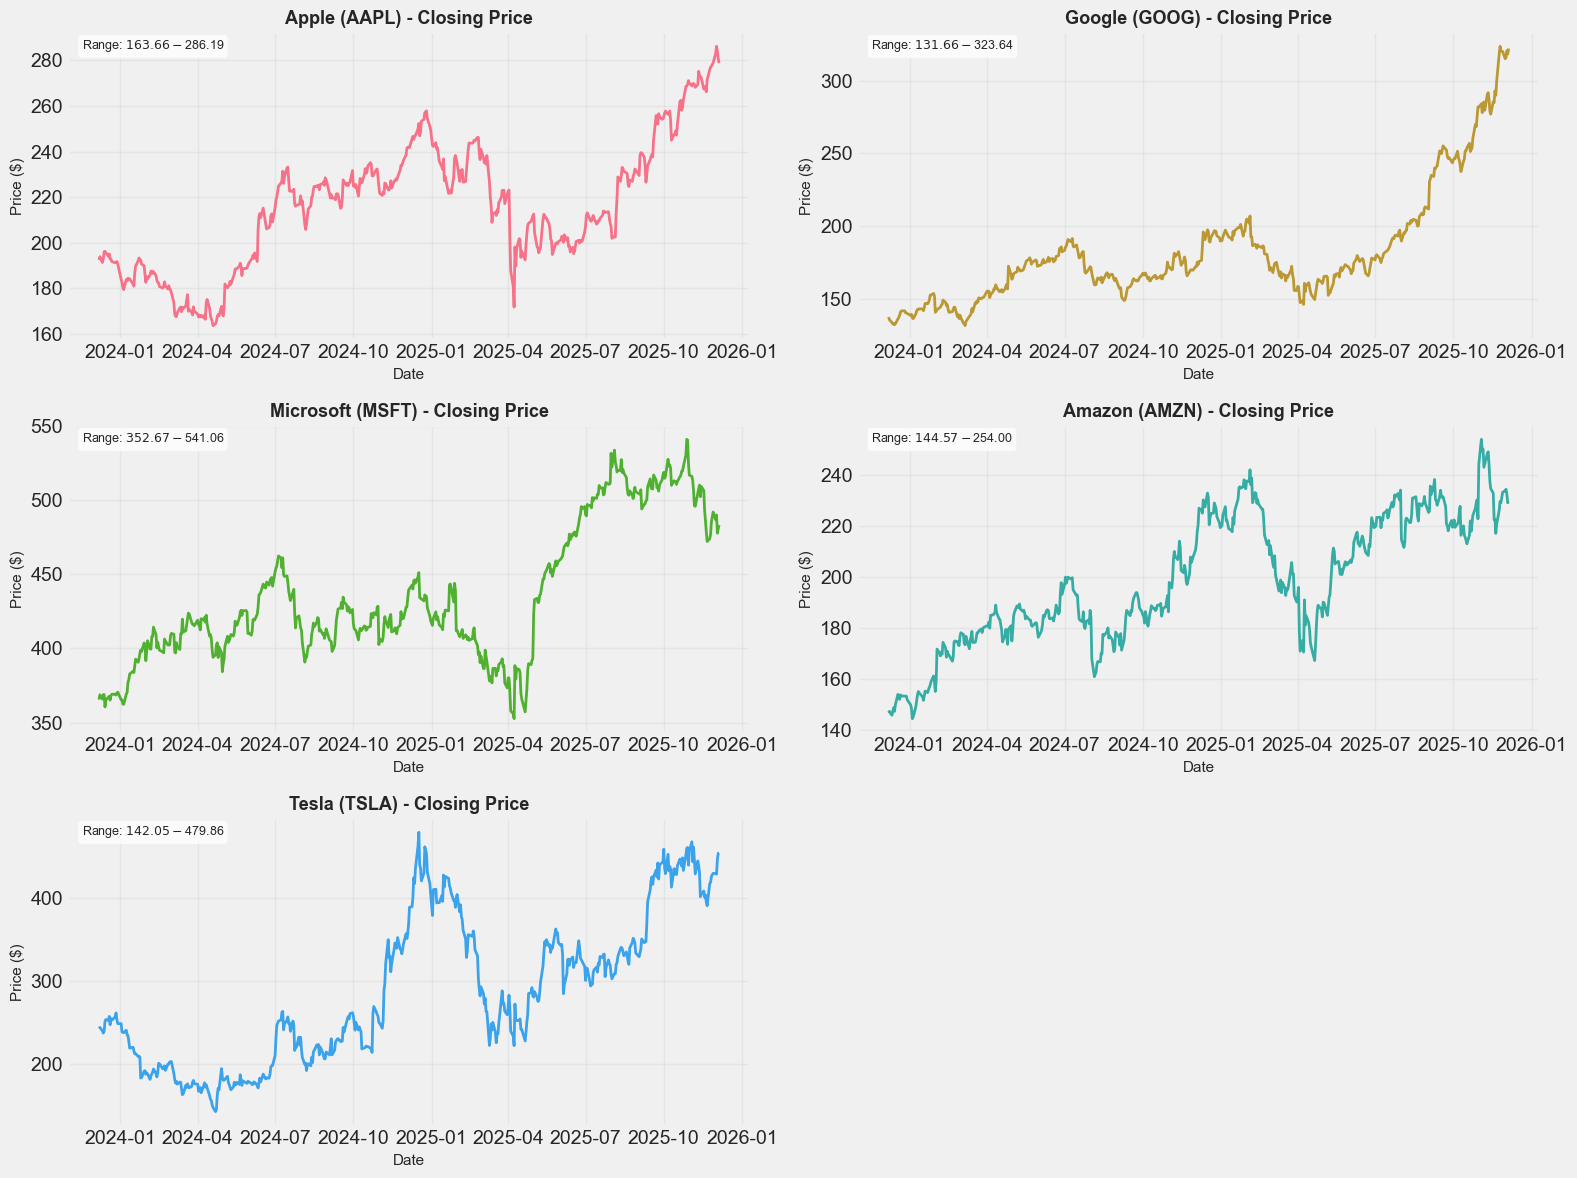

In [4]:
# ============================================================================
# Cell 3: Plot Closing Prices
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (ticker, name) in enumerate(zip(tickers, names)):
    df = stock_data[ticker]
    axes[i].plot(df.index, df['Close'], linewidth=2, color=f'C{i}')
    axes[i].set_title(f'{name} ({ticker}) - Closing Price', fontsize=13, fontweight='bold')
    axes[i].set_ylabel('Price ($)', fontsize=11)
    axes[i].set_xlabel('Date', fontsize=11)
    axes[i].grid(True, alpha=0.3)
    
    # Add price range annotation
    min_price = float(df['Close'].min())
    max_price = float(df['Close'].max())
    axes[i].text(0.02, 0.98, f'Range: ${min_price:.2f} - ${max_price:.2f}', 
                transform=axes[i].transAxes, fontsize=9, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

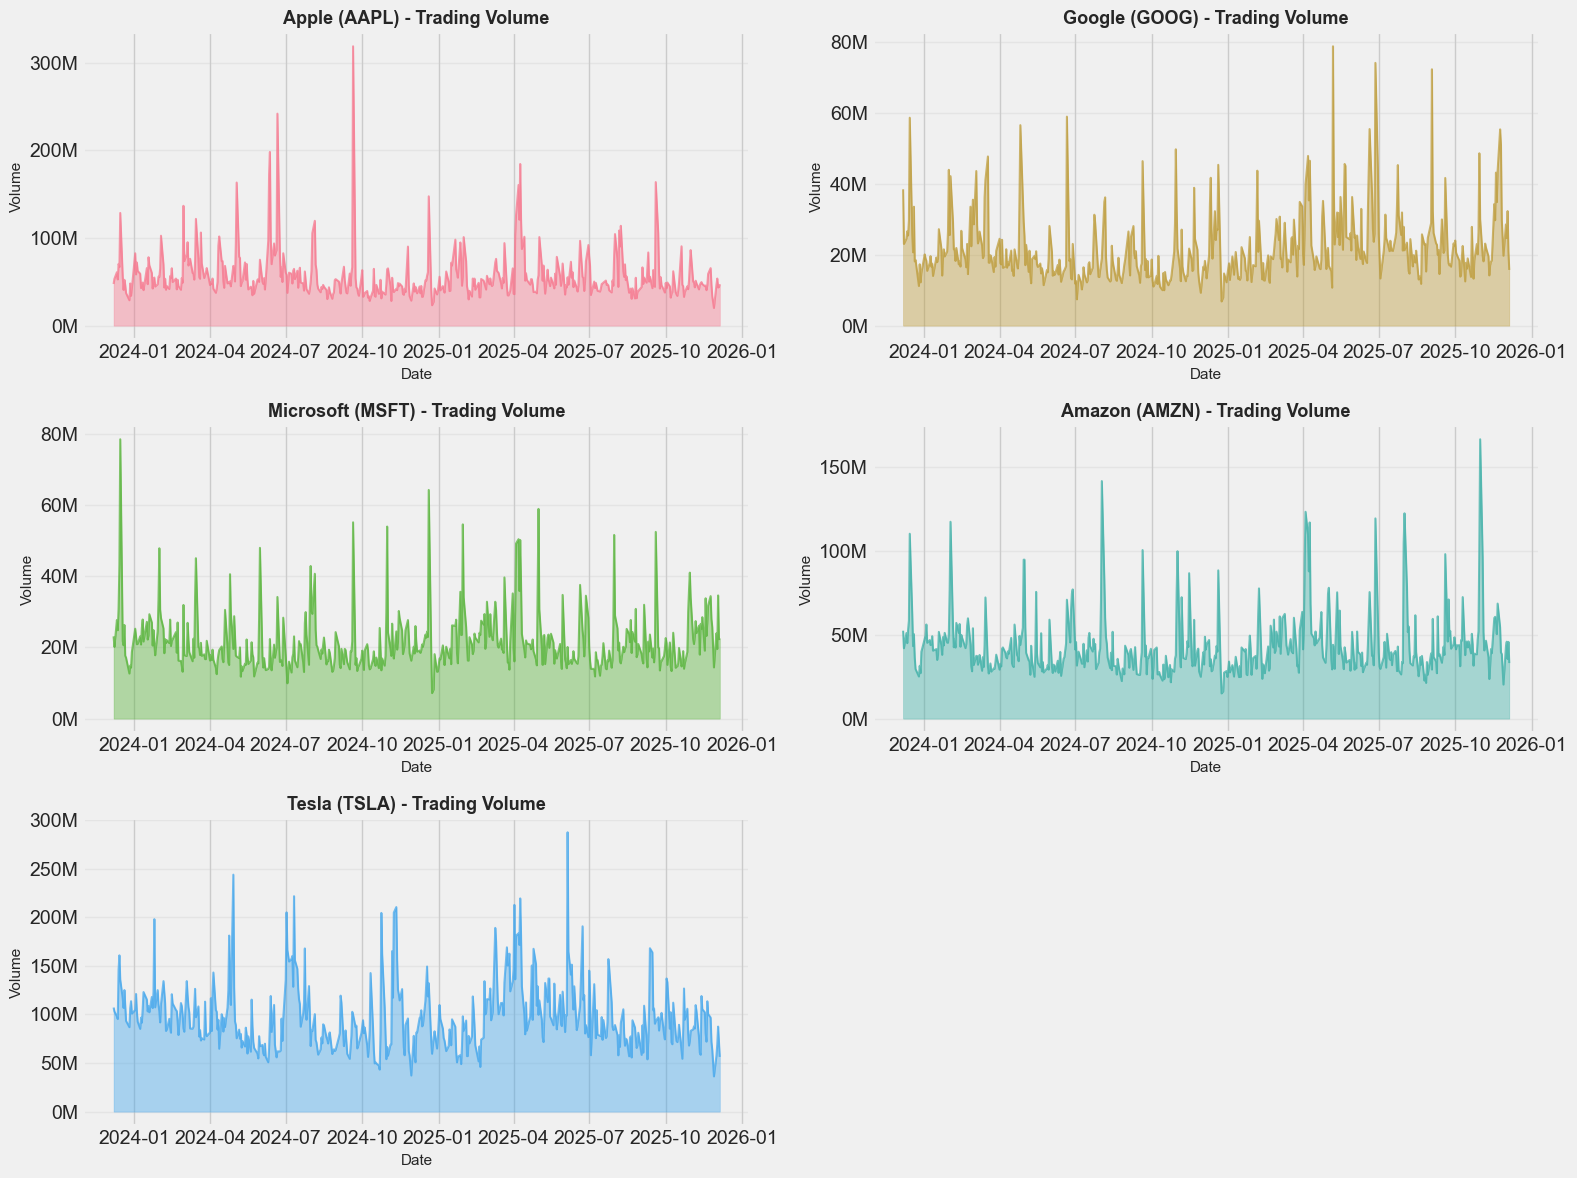

In [5]:
# ============================================================================
# Cell 4: Plot Trading Volume
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (ticker, name) in enumerate(zip(tickers, names)):
    df = stock_data[ticker]
    volume = df['Volume'].squeeze()  # Flatten multi-index if present
    axes[i].plot(df.index, volume, alpha=0.7, color=f'C{i}', linewidth=1.5)
    axes[i].fill_between(df.index, 0, volume, alpha=0.4, color=f'C{i}')
    axes[i].set_title(f'{name} ({ticker}) - Trading Volume', fontsize=13, fontweight='bold')
    axes[i].set_ylabel('Volume', fontsize=11)
    axes[i].set_xlabel('Date', fontsize=11)
    axes[i].grid(True, alpha=0.3, axis='y')
    
    # Format y-axis for millions
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

✅ Moving averages calculated


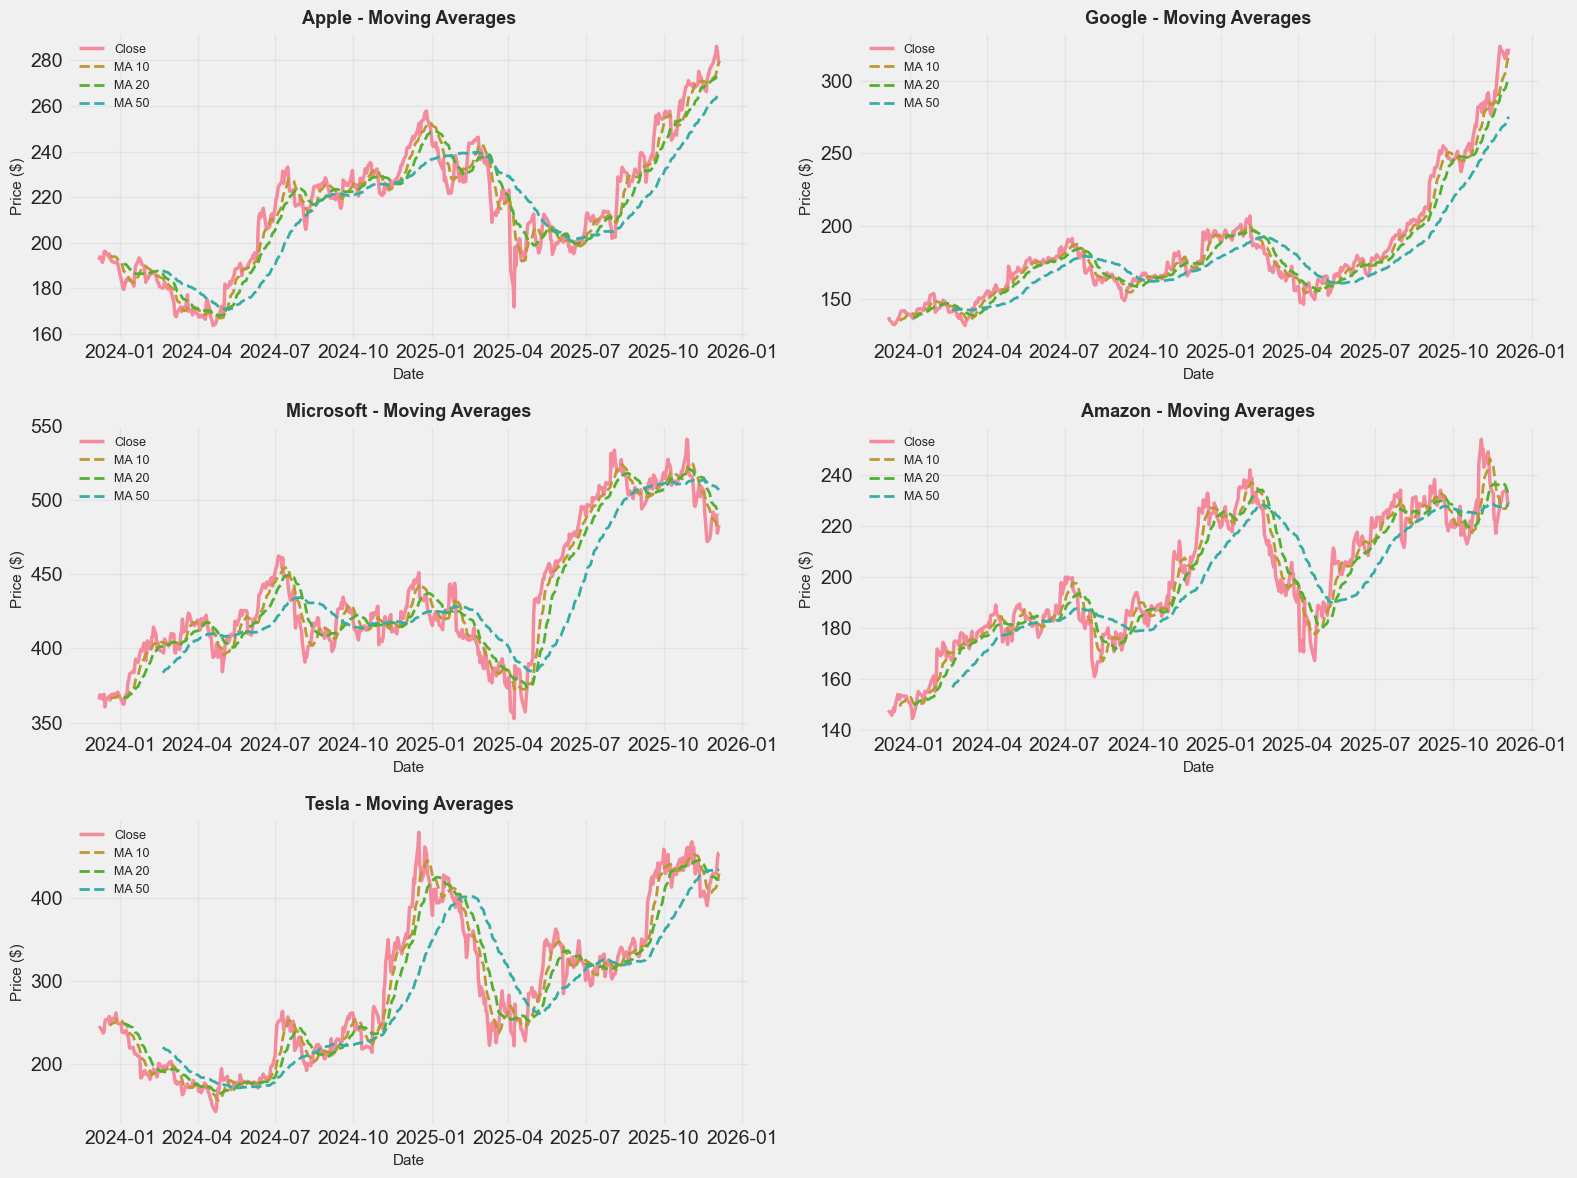

In [6]:
# ============================================================================
# Cell 5: Calculate and Plot Moving Averages
# ============================================================================

# Calculate moving averages
for ticker in tickers:
    df = stock_data[ticker]
    df['MA_10'] = df['Close'].squeeze().rolling(window=10).mean()
    df['MA_20'] = df['Close'].squeeze().rolling(window=20).mean()
    df['MA_50'] = df['Close'].squeeze().rolling(window=50).mean()

print('✅ Moving averages calculated')

# Plot moving averages
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (ticker, name) in enumerate(zip(tickers, names)):
    df = stock_data[ticker]
    close = df['Close'].squeeze()
    ma10 = df['MA_10'].squeeze()
    ma20 = df['MA_20'].squeeze()
    ma50 = df['MA_50'].squeeze()
    
    axes[i].plot(df.index, close, label='Close', linewidth=2.5, alpha=0.8)
    axes[i].plot(df.index, ma10, label='MA 10', linestyle='--', linewidth=2)
    axes[i].plot(df.index, ma20, label='MA 20', linestyle='--', linewidth=2)
    axes[i].plot(df.index, ma50, label='MA 50', linestyle='--', linewidth=2)
    axes[i].set_title(f'{name} - Moving Averages', fontsize=13, fontweight='bold')
    axes[i].set_ylabel('Price ($)', fontsize=11)
    axes[i].set_xlabel('Date', fontsize=11)
    axes[i].legend(fontsize=9, loc='best')
    axes[i].grid(True, alpha=0.3)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


✅ Daily returns calculated


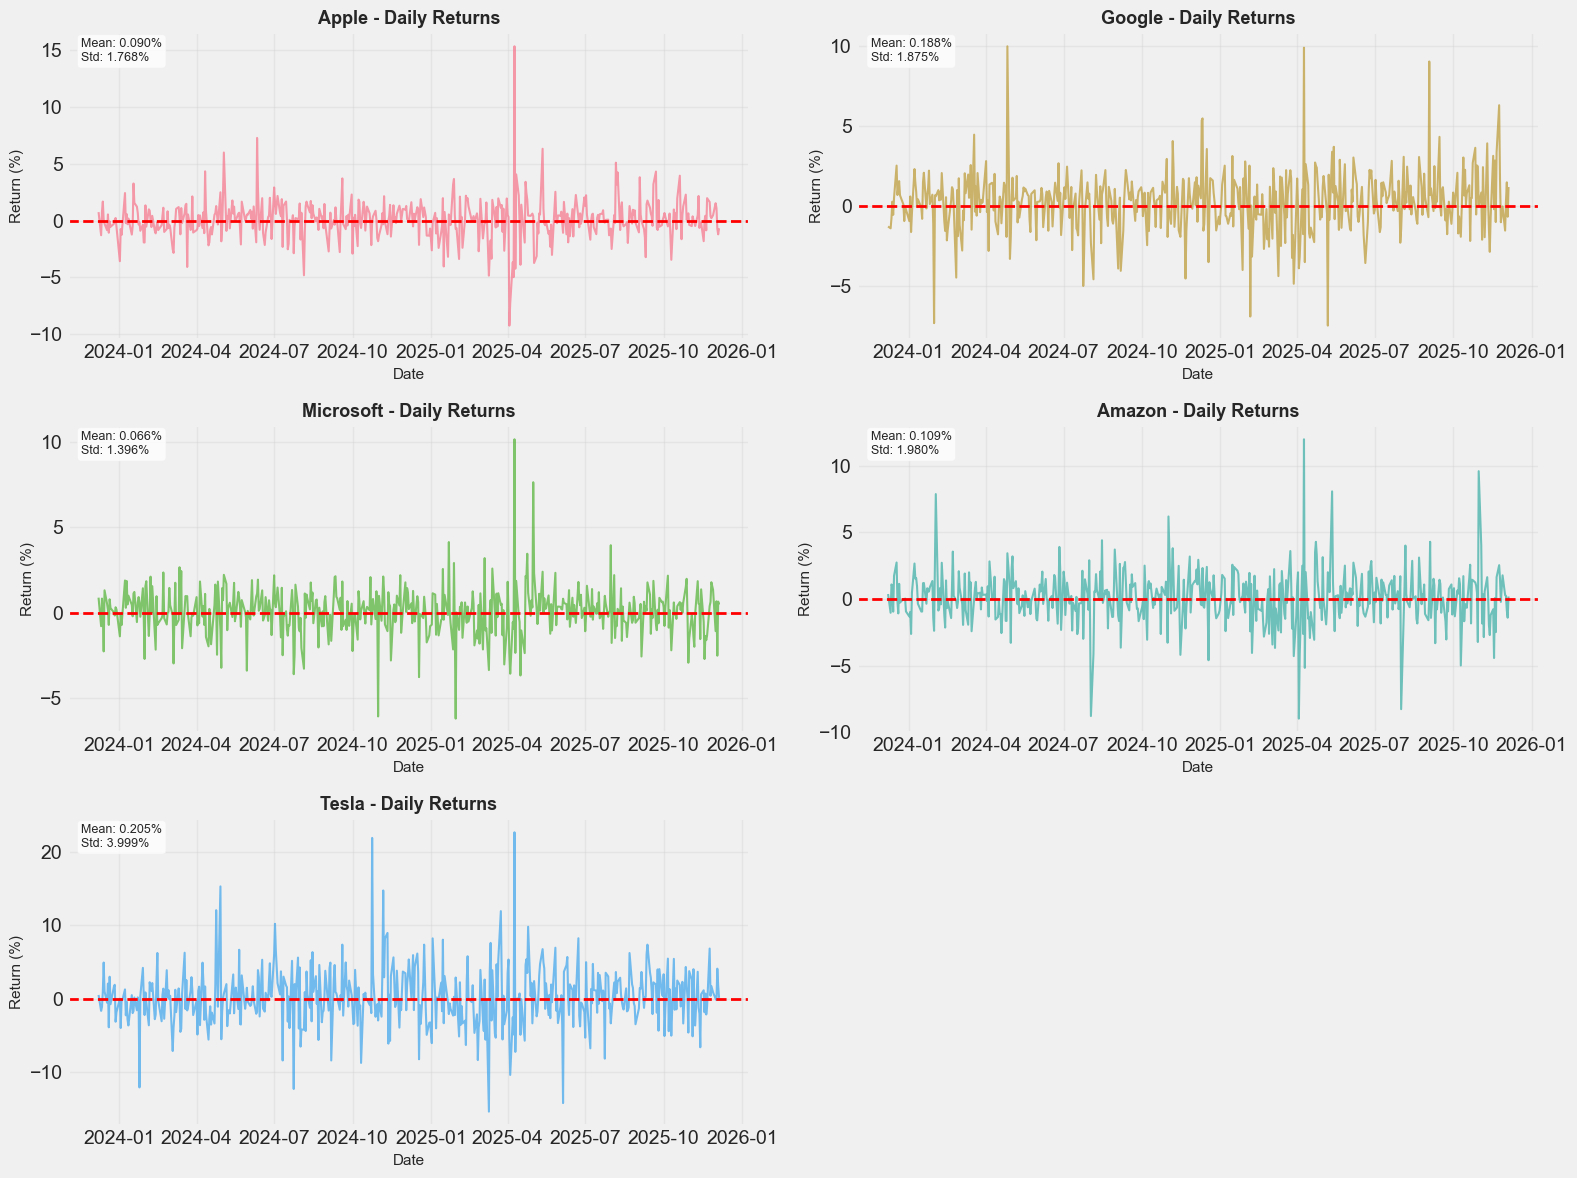

In [7]:
# Cell 6: Calculate and Plot Daily Returns
# ============================================================================

# Calculate daily returns
for ticker in tickers:
    df = stock_data[ticker]
    df['Daily_Return'] = df['Close'].squeeze().pct_change() * 100

print('✅ Daily returns calculated')

# Plot daily returns
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (ticker, name) in enumerate(zip(tickers, names)):
    df = stock_data[ticker]
    returns = df['Daily_Return'].squeeze().dropna()
    
    axes[i].plot(df.index, df['Daily_Return'].squeeze(), linewidth=1.5, alpha=0.7, color=f'C{i}')
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[i].set_title(f'{name} - Daily Returns', fontsize=13, fontweight='bold')
    axes[i].set_ylabel('Return (%)', fontsize=11)
    axes[i].set_xlabel('Date', fontsize=11)
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_ret = float(returns.mean())
    std_ret = float(returns.std())
    axes[i].text(0.02, 0.98, f'Mean: {mean_ret:.3f}%\nStd: {std_ret:.3f}%', 
                transform=axes[i].transAxes, fontsize=9, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

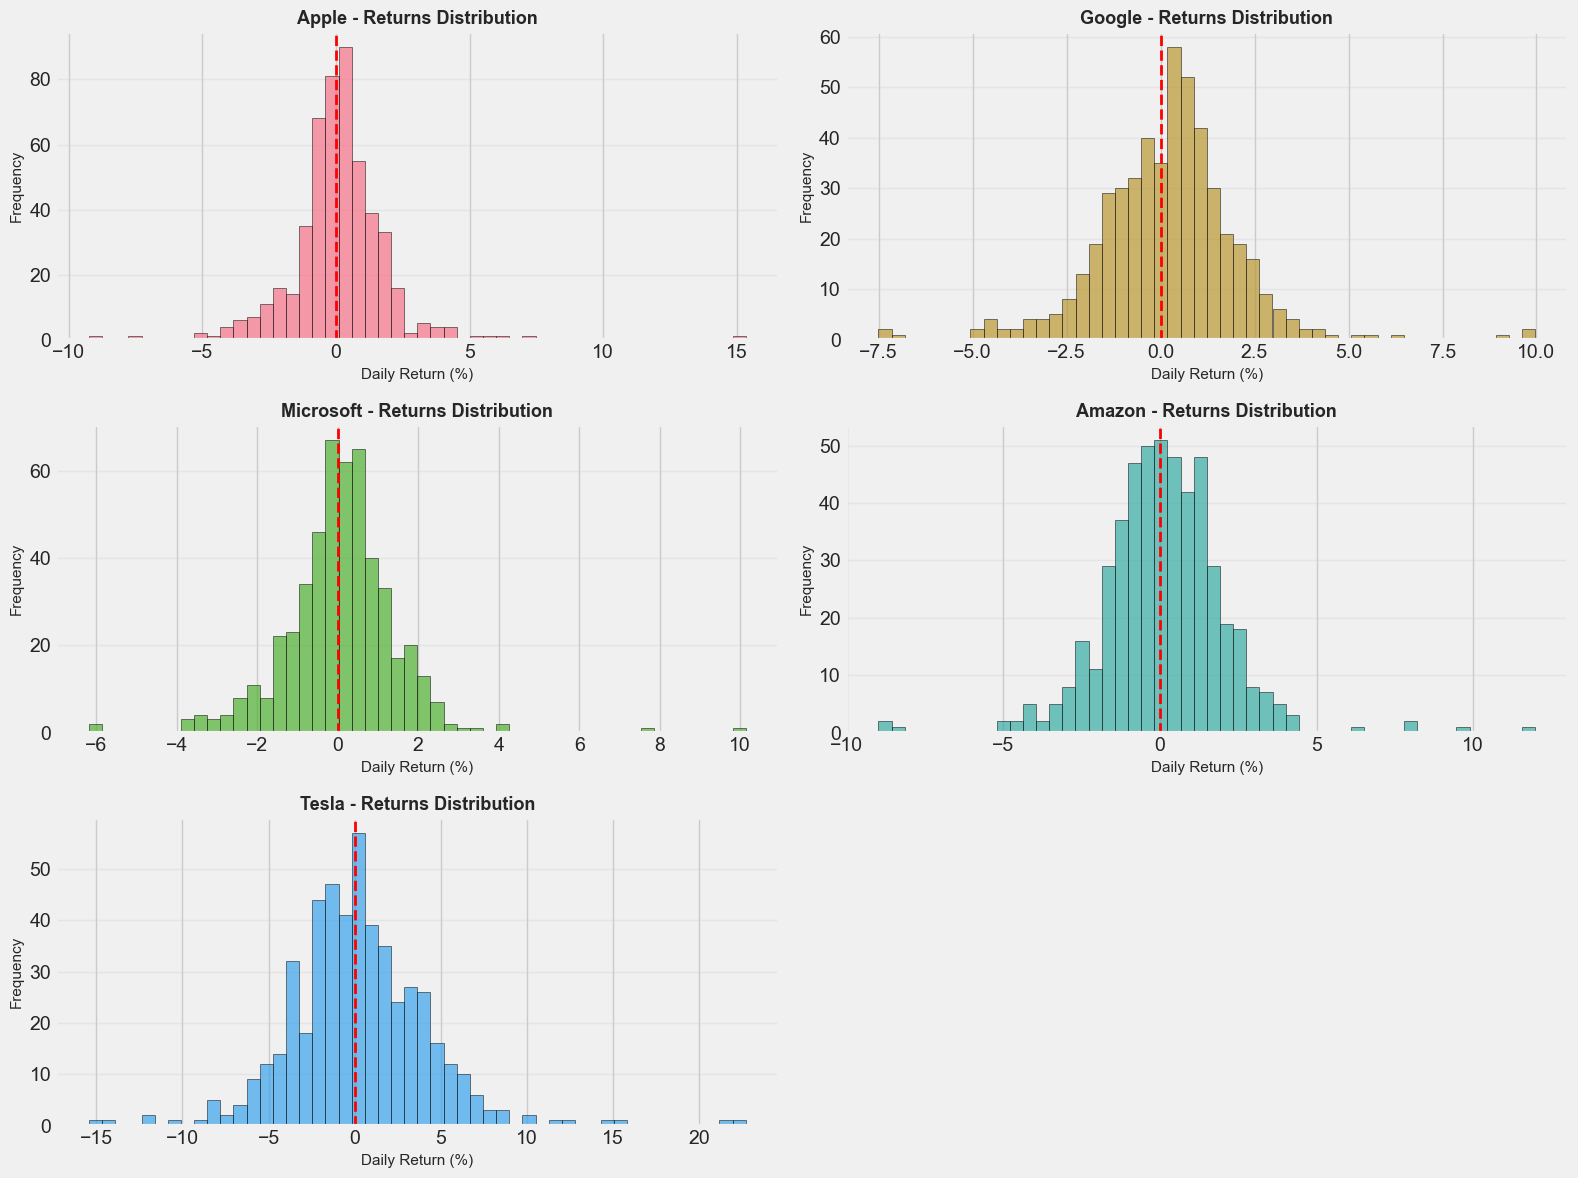

In [8]:
# ============================================================================
# Cell 7: Returns Distribution Analysis
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (ticker, name) in enumerate(zip(tickers, names)):
    df = stock_data[ticker]
    returns = df['Daily_Return'].squeeze().dropna()
    
    axes[i].hist(returns, bins=50, alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[i].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[i].set_title(f'{name} - Returns Distribution', fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Daily Return (%)', fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)
    axes[i].grid(True, alpha=0.3, axis='y')

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

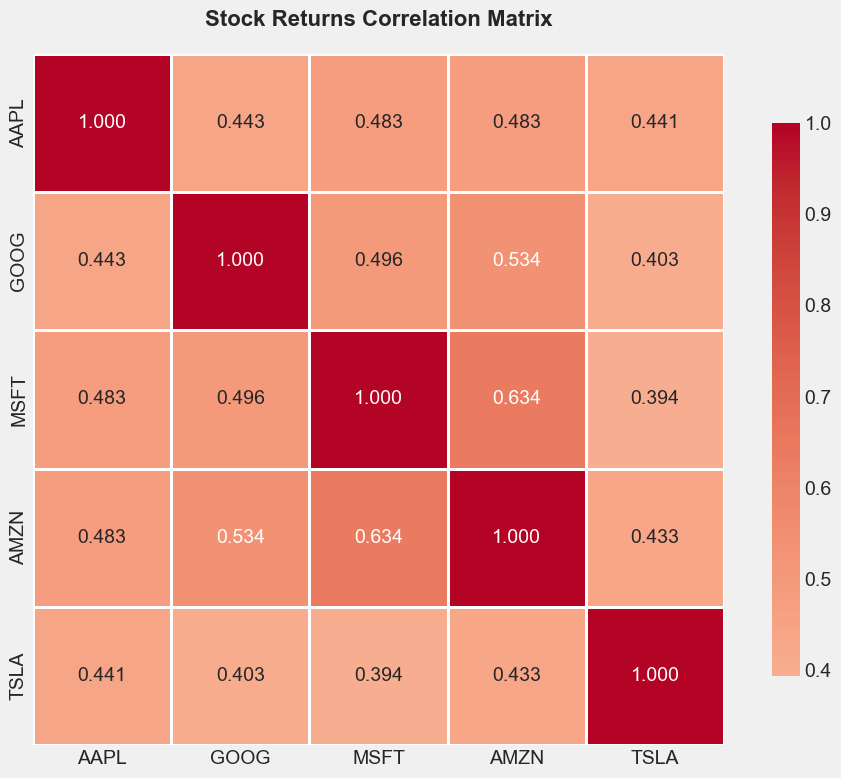

In [9]:
# Cell 8: Correlation Analysis
# ============================================================================

# Create returns dataframe
returns = pd.DataFrame({t: stock_data[t]['Daily_Return'].squeeze() for t in tickers})
returns_clean = returns.dropna()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(returns_clean.corr(), annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=2, cbar_kws={"shrink": 0.8})
plt.title('Stock Returns Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

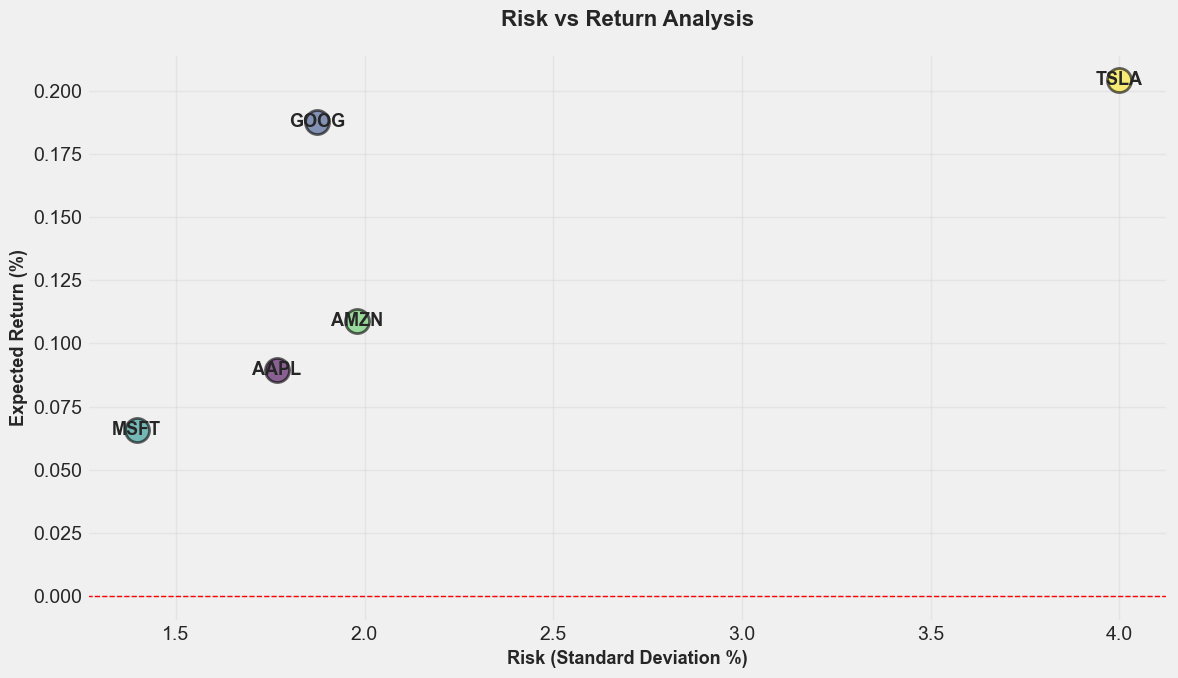


📊 Risk vs Return Summary:
AAPL  | Return:   0.090% | Risk:  1.768%
GOOG  | Return:   0.188% | Risk:  1.875%
MSFT  | Return:   0.066% | Risk:  1.396%
AMZN  | Return:   0.109% | Risk:  1.980%
TSLA  | Return:   0.205% | Risk:  3.999%


In [10]:
# Cell 9: Risk vs Return Analysis
# ============================================================================

mean_returns = returns_clean.mean()
std_returns = returns_clean.std()

# Scale data - FIT ONLY on training data to prevent data leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataset[:train_size])  # Fit only on training data
scaled_data = scaler.transform(dataset)  # Transform entire dataset
\n
for i, ticker in enumerate(tickers):
    plt.scatter(float(std_returns[ticker]), float(mean_returns[ticker]), 
               s=300, alpha=0.6, color=colors[i], edgecolors='black', linewidth=2)
    plt.annotate(ticker, (float(std_returns[ticker]), float(mean_returns[ticker])), 
                fontsize=13, fontweight='bold', ha='center', va='center')

plt.xlabel('Risk (Standard Deviation %)', fontsize=13, fontweight='bold')
plt.ylabel('Expected Return (%)', fontsize=13, fontweight='bold')
plt.title('Risk vs Return Analysis', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

print('\n📊 Risk vs Return Summary:')
print('='*50)
for ticker in tickers:
    print(f'{ticker:5} | Return: {float(mean_returns[ticker]):7.3f}% | Risk: {float(std_returns[ticker]):6.3f}%')
print('='*50)

In [21]:
# Cell 10: Prepare LSTM Data
# ============================================================================

print('\n🤖 Preparing data for LSTM model...\n')

# Download more data for LSTM (5 years)
lstm_data = yf.download('AAPL', start='2019-01-01', end=end, progress=False)
if lstm_data.index.tz is not None:
    lstm_data.index = lstm_data.index.tz_localize(None)

# Prepare data
data = pd.DataFrame(lstm_data['Close'].squeeze())
dataset = data.values

# Split: 70% train, 15% val, 15% test
train_size = int(len(dataset) * 0.70)
val_size = int(len(dataset) * 0.85)

# Scale data - FIT ONLY on training data to prevent data leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataset[:train_size])  # Fit only on training data
scaled_data = scaler.transform(dataset)  # Transform entire dataset

print(f'📈 Total samples: {len(dataset)}')
print(f'   Training:   {train_size} samples ({train_size/len(dataset)*100:.1f}%)')
print(f'   Validation: {val_size-train_size} samples ({(val_size-train_size)/len(dataset)*100:.1f}%)')
print(f'   Testing:    {len(dataset)-val_size} samples ({(len(dataset)-val_size)/len(dataset)*100:.1f}%)')


🤖 Preparing data for LSTM model...

📈 Total samples: 1743
   Training:   1220 samples (70.0%)
   Validation: 261 samples (15.0%)
   Testing:    262 samples (15.0%)


In [12]:
# Cell 11: Create Dataset Class and Data Loaders
# ============================================================================

class StockDataset(Dataset):
    """Custom Dataset for stock price sequences"""
    def __init__(self, data, seq_len=60):
        self.data = torch.FloatTensor(data)
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        return (self.data[idx:idx+self.seq_len], 
                self.data[idx+self.seq_len])

# Create datasets
SEQ_LENGTH = 60
BATCH_SIZE = 32

train_dataset = StockDataset(scaled_data[:train_size], seq_len=SEQ_LENGTH)
val_dataset = StockDataset(scaled_data[train_size-SEQ_LENGTH:val_size], seq_len=SEQ_LENGTH)
test_dataset = StockDataset(scaled_data[val_size-SEQ_LENGTH:], seq_len=SEQ_LENGTH)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'\n✅ Datasets created successfully!')
print(f'   Sequence length: {SEQ_LENGTH}')
print(f'   Batch size: {BATCH_SIZE}')
print(f'   Train batches: {len(train_loader)}')
print(f'   Val batches: {len(val_loader)}')
print(f'   Test batches: {len(test_loader)}')


✅ Datasets created successfully!
   Sequence length: 60
   Batch size: 32
   Train batches: 37
   Val batches: 9
   Test batches: 9


In [22]:
# Cell 12: Define Enhanced LSTM Model
# ============================================================================

class EnhancedLSTM(nn.Module):
    """Enhanced LSTM model with dropout and batch normalization"""
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(EnhancedLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Take the last time step
        out = lstm_out[:, -1, :]
        
        # Fully connected layers with dropout
        out = self.dropout(self.relu(self.fc1(out)))
        out = self.dropout(self.relu(self.fc2(out)))
        out = self.fc3(out)
        
        return out

# Initialize model
model = EnhancedLSTM(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    dropout=0.2
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                        factor=0.5, patience=5, verbose=True)

print('✅ Enhanced LSTM model created!')
print(f'\n📊 Model Architecture:')
print('='*60)
print(model)
print('='*60)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

✅ Enhanced LSTM model created!

📊 Model Architecture:
EnhancedLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 209,537
Trainable parameters: 209,537


In [23]:
# Cell 13: Training Loop
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            predictions = model(x)
            loss = criterion(predictions, y)
            total_loss += loss.item()
    
    return total_loss / len(loader)

# Training
EPOCHS = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')

print('\n🚀 Starting training...\n')
print('='*70)

# MLflow Tracking
mlflow.set_experiment("Stock_Price_Prediction_LSTM")
if mlflow.active_run():
    mlflow.end_run()
mlflow.start_run()

# Log Parameters
mlflow.log_params({
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'sequence_length': SEQ_LENGTH,
    'hidden_size': model.hidden_size,
    'num_layers': model.num_layers,
    'dropout': 0.2,
    'learning_rate': 0.001
})

for epoch in range(EPOCHS):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        # Log metrics
        mlflow.log_metrics({'train_loss': train_loss, 'val_loss': val_loss}, step=epoch)
        print(f'Epoch [{epoch+1:3d}/{EPOCHS}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')

print('='*70)
print(f'\n✅ Training complete!')
print(f'   Best validation loss: {best_val_loss:.6f}')

# Load best model
model.load_state_dict(torch.load('best_lstm_model.pth'))

# Log model and end run
with torch.no_grad():
    example_input = torch.zeros(1, SEQ_LENGTH, 1).to(device)
    signature = mlflow.models.infer_signature(example_input.cpu().numpy(), model(example_input).cpu().numpy())
    mlflow.pytorch.log_model(model, "lstm_model", signature=signature)
mlflow.end_run()



🚀 Starting training...

Epoch [ 10/100] | Train Loss: 0.003447 | Val Loss: 0.001073
Epoch [ 20/100] | Train Loss: 0.002417 | Val Loss: 0.001610
Epoch [ 30/100] | Train Loss: 0.001943 | Val Loss: 0.001339
Epoch [ 40/100] | Train Loss: 0.001584 | Val Loss: 0.000949
Epoch [ 50/100] | Train Loss: 0.001548 | Val Loss: 0.002070
Epoch [ 60/100] | Train Loss: 0.001637 | Val Loss: 0.001884
Epoch [ 70/100] | Train Loss: 0.001636 | Val Loss: 0.001453
Epoch [ 80/100] | Train Loss: 0.001568 | Val Loss: 0.001605
Epoch [ 90/100] | Train Loss: 0.001452 | Val Loss: 0.001602


2025/12/07 19:48:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [100/100] | Train Loss: 0.001570 | Val Loss: 0.001654

✅ Training complete!
   Best validation loss: 0.000425


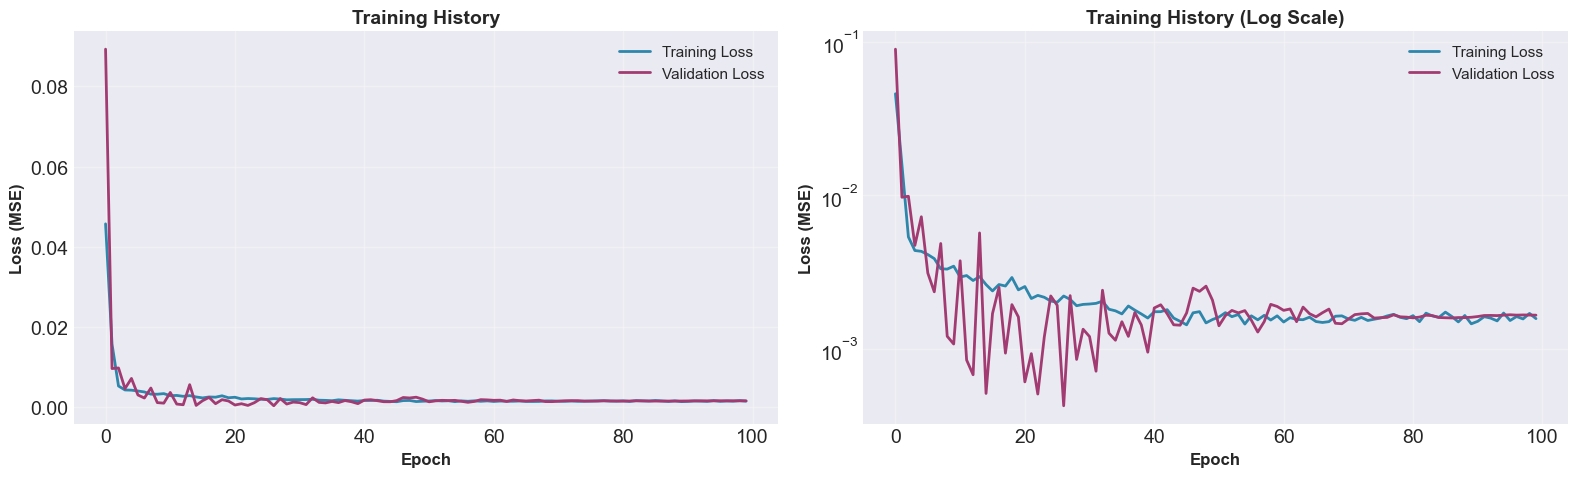

In [24]:
# Cell 14: Plot Training History
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Loss curves
ax1.plot(train_losses, label='Training Loss', linewidth=2, color='#2E86AB')
ax1.plot(val_losses, label='Validation Loss', linewidth=2, color='#A23B72')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
ax1.set_title('Training History', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Log scale
ax2.plot(train_losses, label='Training Loss', linewidth=2, color='#2E86AB')
ax2.plot(val_losses, label='Validation Loss', linewidth=2, color='#A23B72')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
ax2.set_title('Training History (Log Scale)', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Cell 15: Make Predictions and Calculate Metrics
# ============================================================================

print('\n🔮 Making predictions...\n')

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model(x)
        predictions.extend(pred.cpu().numpy())
        actuals.extend(y.numpy())

# Inverse transform to get actual prices
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Calculate comprehensive metrics
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
r2 = r2_score(actuals, predictions)
accuracy = (1 - (mae / actuals.mean())) * 100

print('📊 Model Performance Metrics:')
print('='*60)
print(f'   RMSE (Root Mean Squared Error): ${rmse:.2f}')
print(f'   MAE (Mean Absolute Error):      ${mae:.2f}')
print(f'   MAPE (Mean Absolute % Error):   {mape:.2f}%')
print(f'   R² Score:                       {r2:.4f}')
print(f'   Accuracy:                       {accuracy:.2f}%')
print('='*60)


🔮 Making predictions...

📊 Model Performance Metrics:
   RMSE (Root Mean Squared Error): $5.42
   MAE (Mean Absolute Error):      $4.22
   MAPE (Mean Absolute % Error):   2.69%
   R² Score:                       0.8739
   Accuracy:                       97.34%


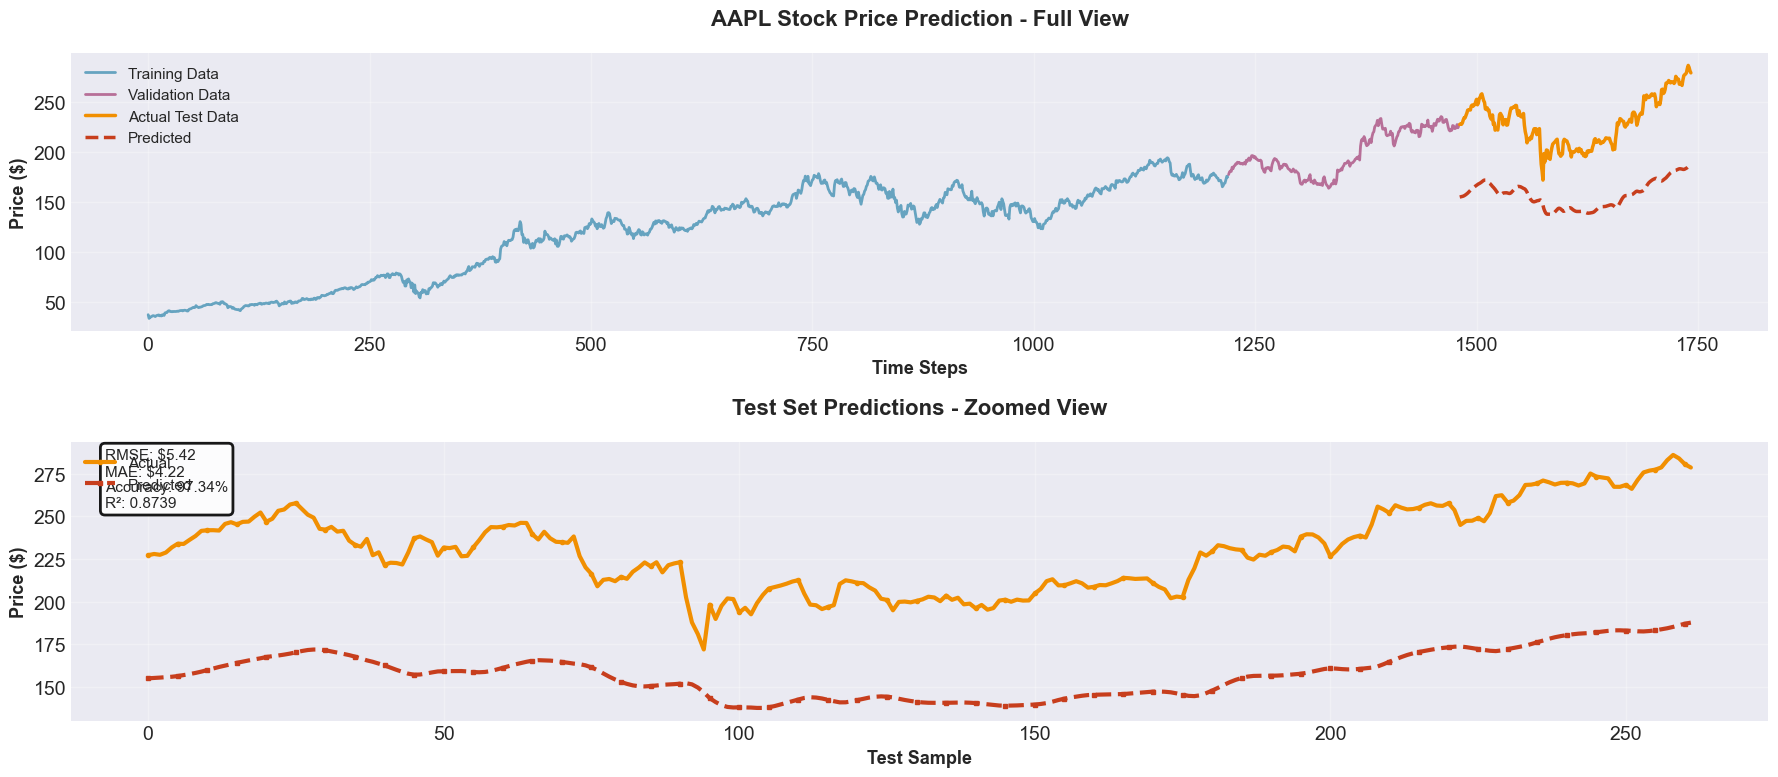

In [26]:
# ============================================================================
# Cell 16: Visualize Predictions
# ============================================================================

# Prepare data for visualization
train_close = data[:train_size].values.flatten()
val_close = data[train_size:val_size].values.flatten()
test_close = data[val_size:].values.flatten()
test_close = test_close[-len(predictions):]
pred_flat = predictions.flatten()

# Create figure
fig = plt.figure(figsize=(18, 8))

# Main plot
ax1 = plt.subplot(2, 1, 1)
ax1.plot(train_close, label='Training Data', alpha=0.7, linewidth=2, color='#2E86AB')
ax1.plot(range(len(train_close), len(train_close) + len(val_close)), 
         val_close, label='Validation Data', alpha=0.7, linewidth=2, color='#A23B72')
ax1.plot(range(len(train_close) + len(val_close), 
               len(train_close) + len(val_close) + len(test_close)), 
         test_close, label='Actual Test Data', linewidth=2.5, color='#F18F01')
ax1.plot(range(len(train_close) + len(val_close), 
               len(train_close) + len(val_close) + len(pred_flat)), 
         pred_flat, label='Predicted', linewidth=2.5, linestyle='--', color='#C73E1D')

ax1.set_title('AAPL Stock Price Prediction - Full View', fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Price ($)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Time Steps', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)

# Zoomed plot (test data only)
ax2 = plt.subplot(2, 1, 2)
ax2.plot(test_close, label='Actual', linewidth=3, color='#F18F01', marker='o', 
         markersize=3, markevery=5)
ax2.plot(pred_flat, label='Predicted', linewidth=3, linestyle='--', 
         color='#C73E1D', marker='s', markersize=3, markevery=5)

ax2.set_title('Test Set Predictions - Zoomed View', fontsize=16, fontweight='bold', pad=20)
ax2.set_ylabel('Price ($)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Test Sample', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3)

# Add metrics box
metrics_text = f'RMSE: ${rmse:.2f}\nMAE: ${mae:.2f}\nAccuracy: {accuracy:.2f}%\nR²: {r2:.4f}'
ax2.text(0.02, 0.98, metrics_text, transform=ax2.transAxes, 
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

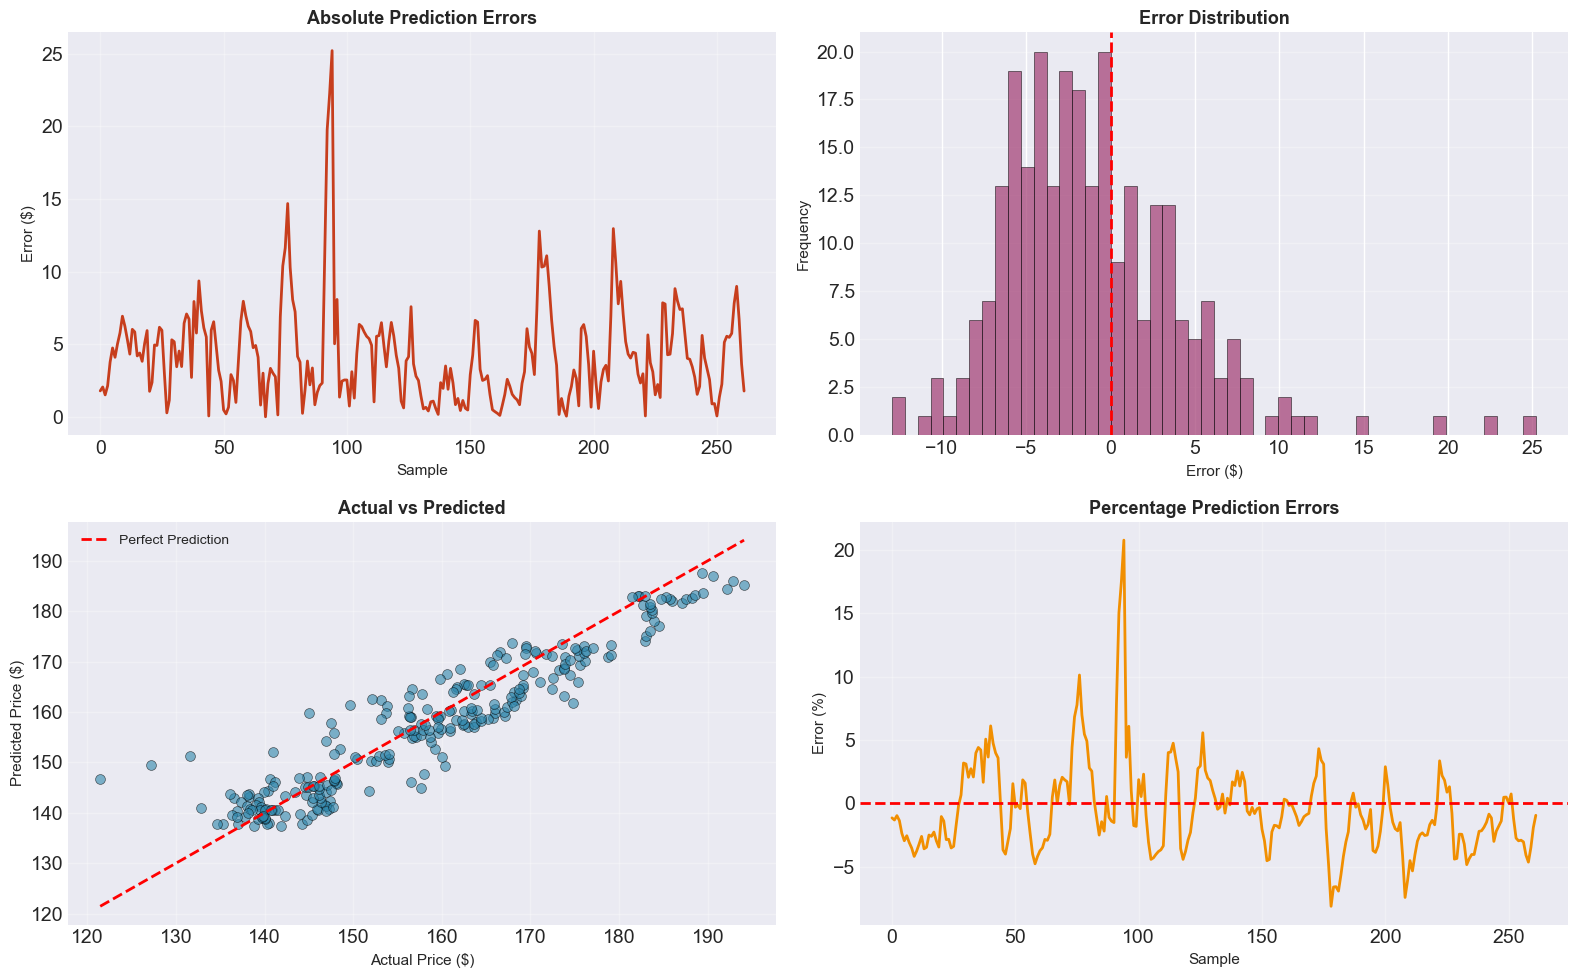


✅ Analysis complete! Model is ready for predictions.


In [27]:
# ============================================================================
# Cell 17: Prediction Error Analysis
# ============================================================================

errors = predictions - actuals
error_percentage = (errors / actuals) * 100

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Absolute errors over time
axes[0, 0].plot(np.abs(errors), linewidth=2, color='#C73E1D')
axes[0, 0].set_title('Absolute Prediction Errors', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Error ($)', fontsize=11)
axes[0, 0].set_xlabel('Sample', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Error distribution
axes[0, 1].hist(errors, bins=50, alpha=0.7, color='#A23B72', edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Error Distribution', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Error ($)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Actual vs Predicted scatter
axes[1, 0].scatter(actuals, predictions, alpha=0.6, s=50, color='#2E86AB', edgecolors='black')
axes[1, 0].plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Actual vs Predicted', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Actual Price ($)', fontsize=11)
axes[1, 0].set_ylabel('Predicted Price ($)', fontsize=11)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Percentage error over time
axes[1, 1].plot(error_percentage, linewidth=2, color='#F18F01')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Percentage Prediction Errors', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Error (%)', fontsize=11)
axes[1, 1].set_xlabel('Sample', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n✅ Analysis complete! Model is ready for predictions.')